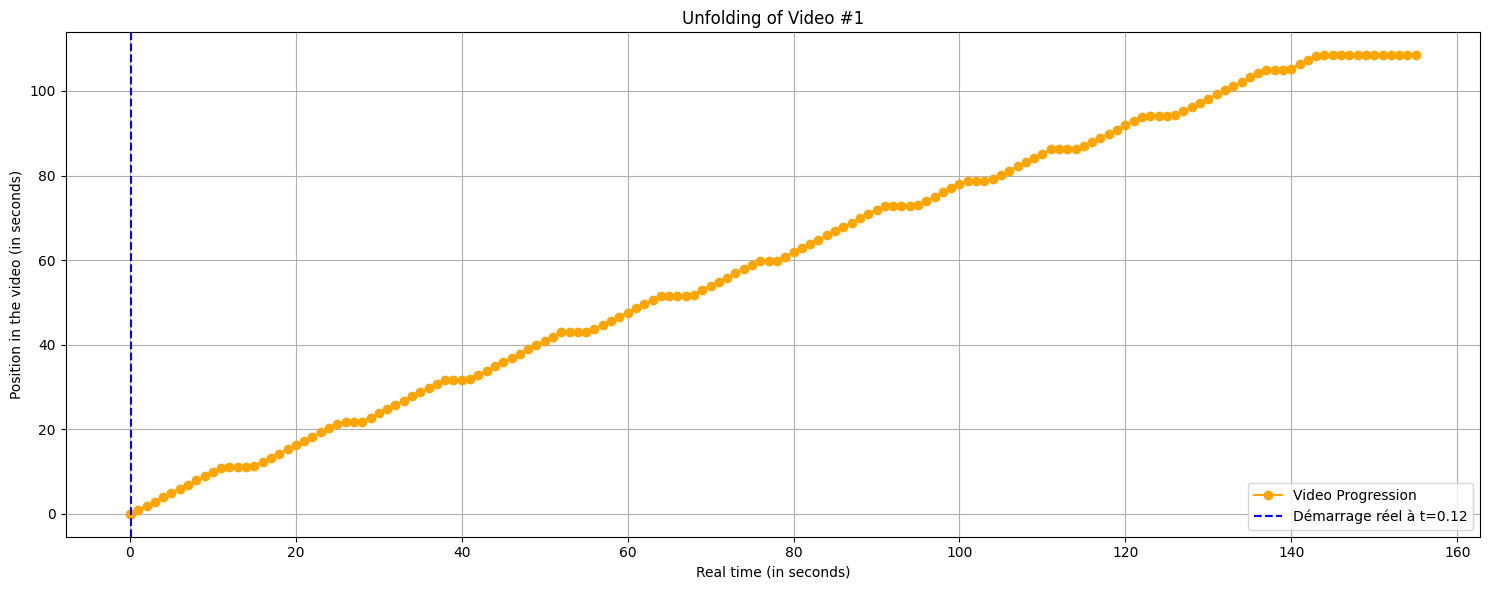

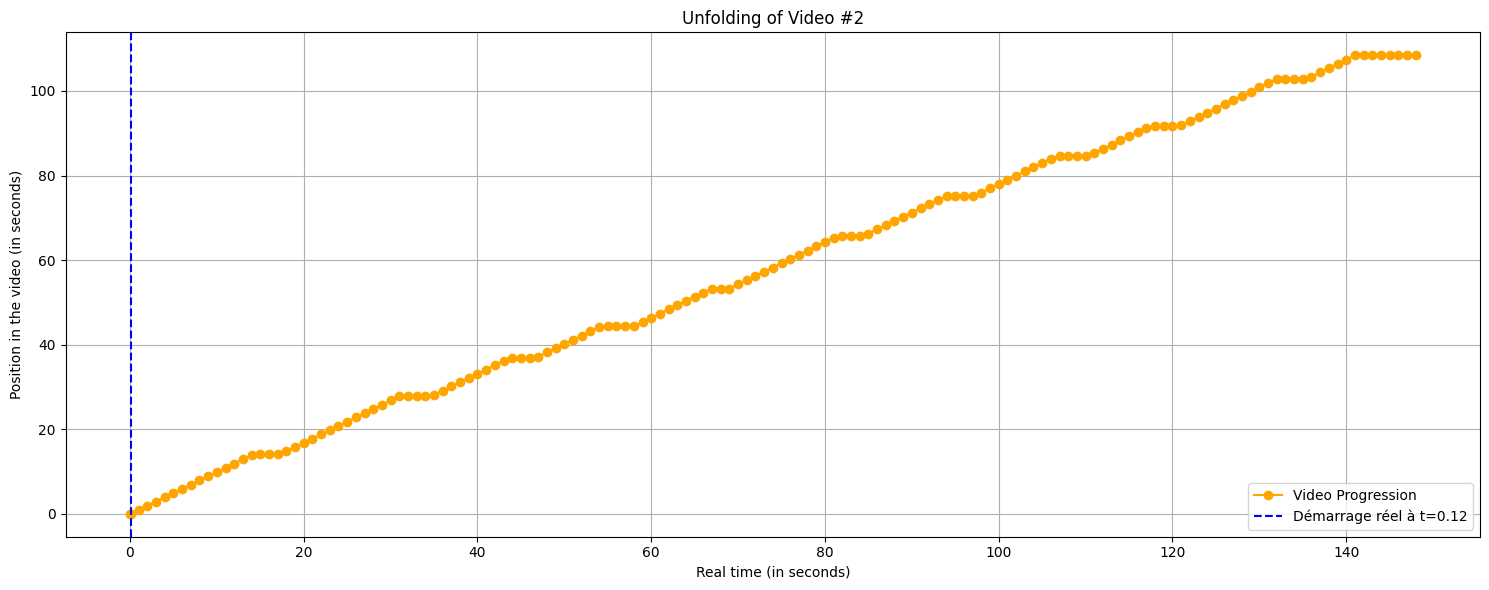

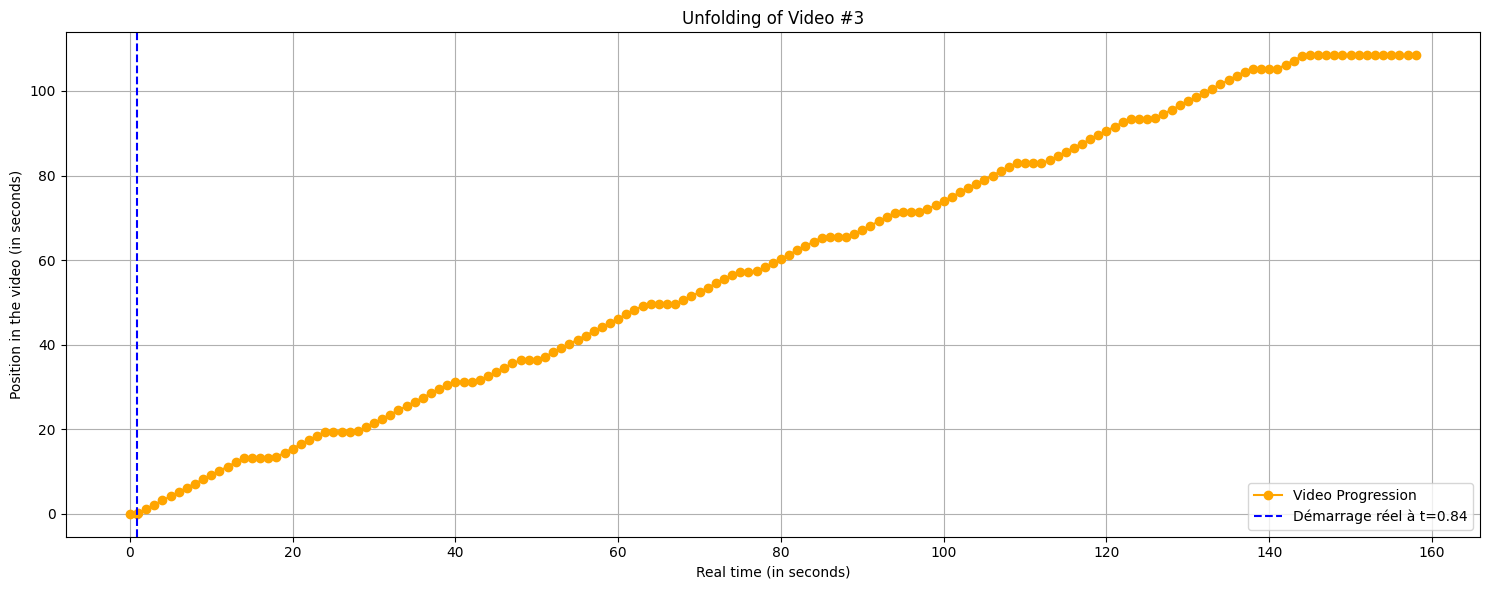

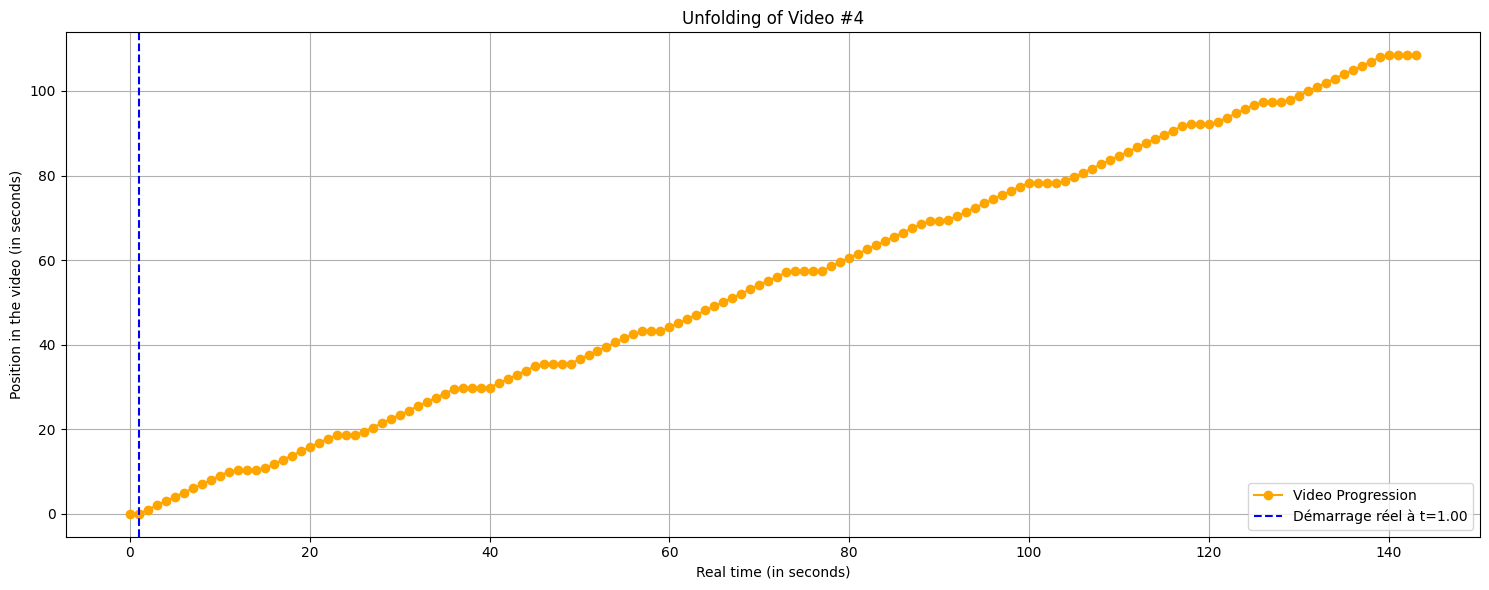

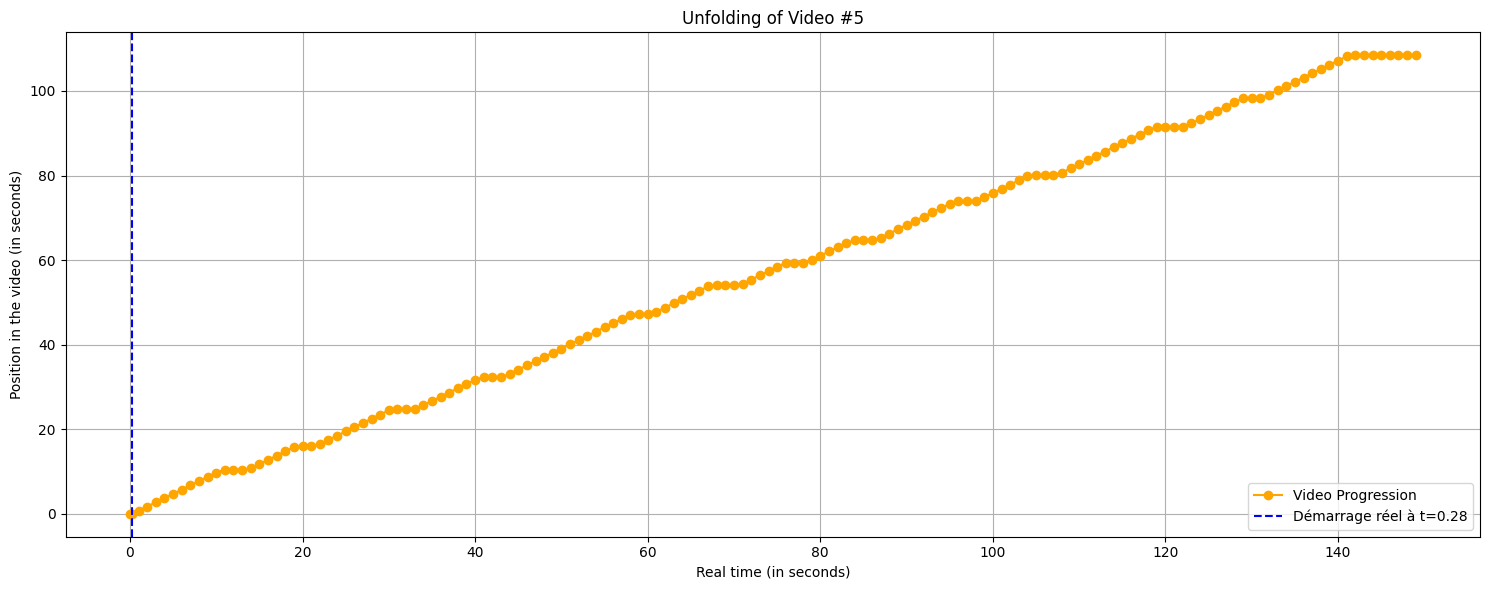

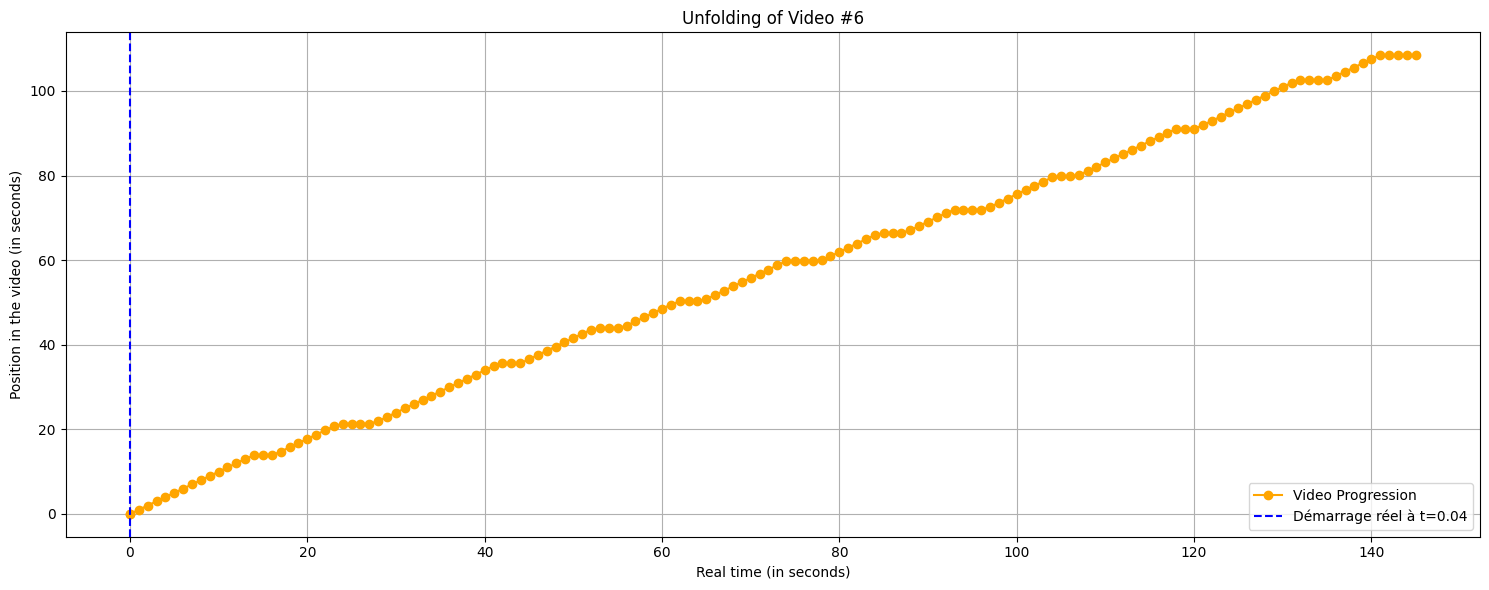

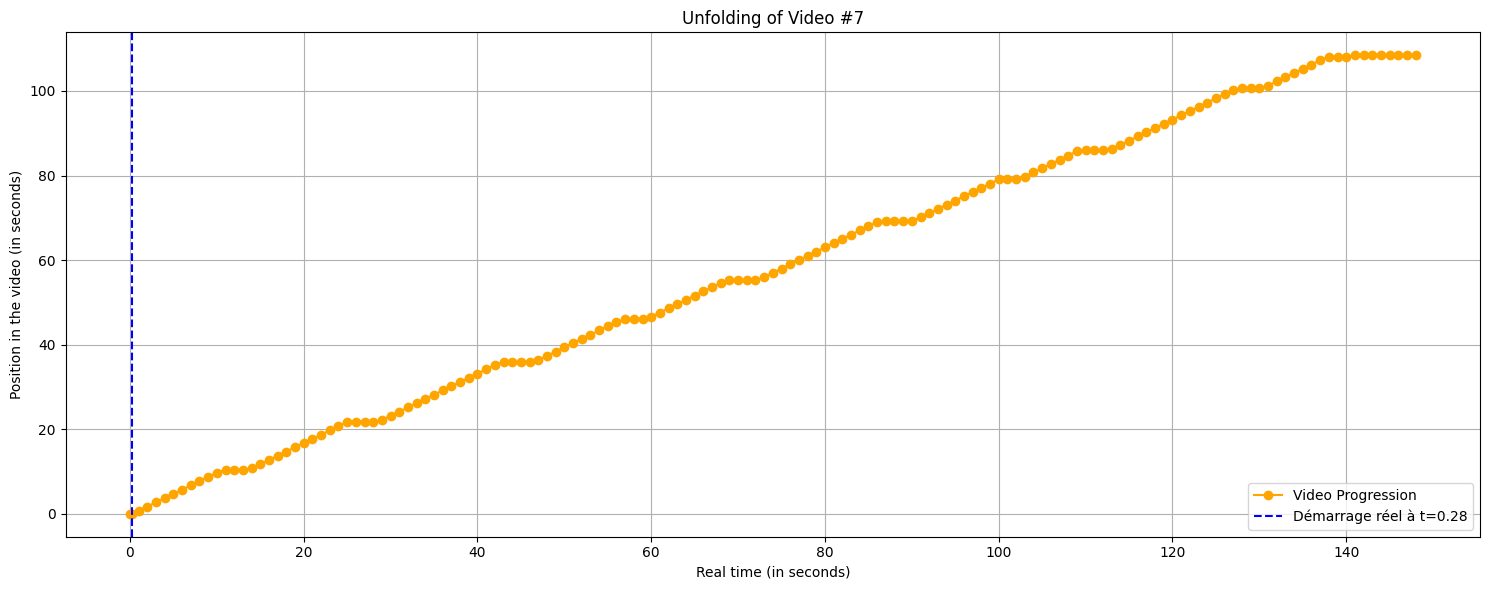

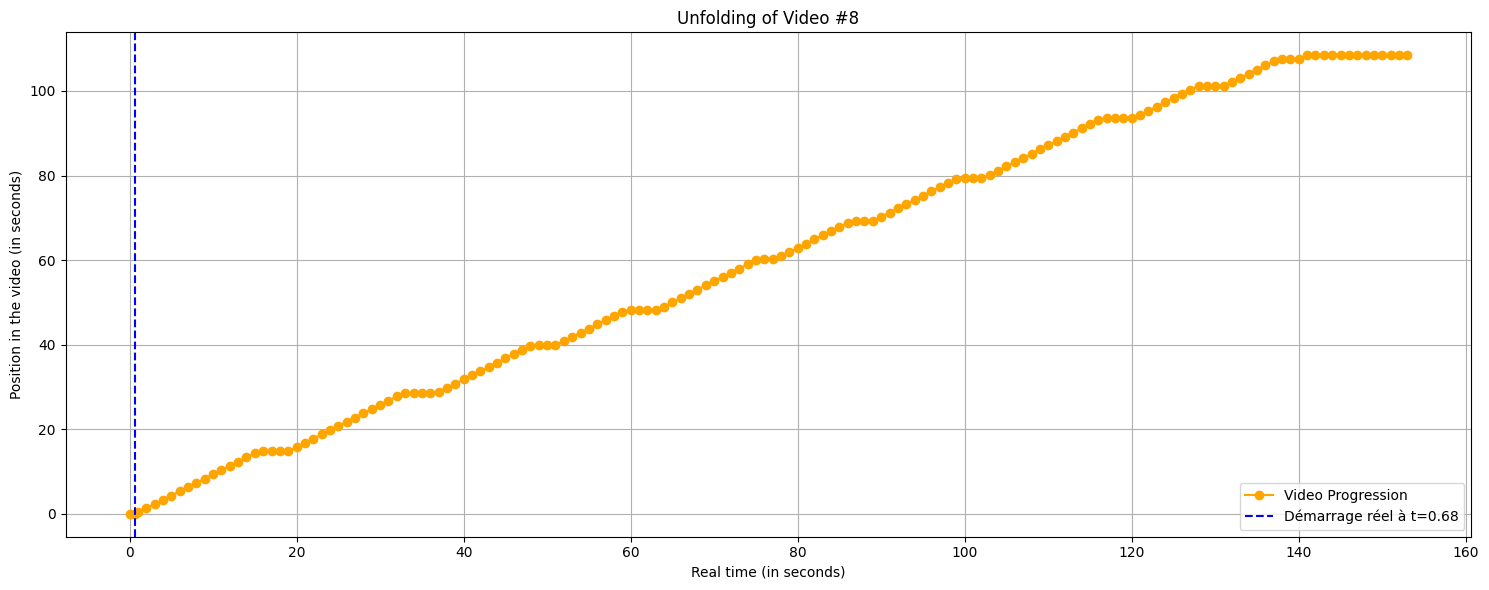

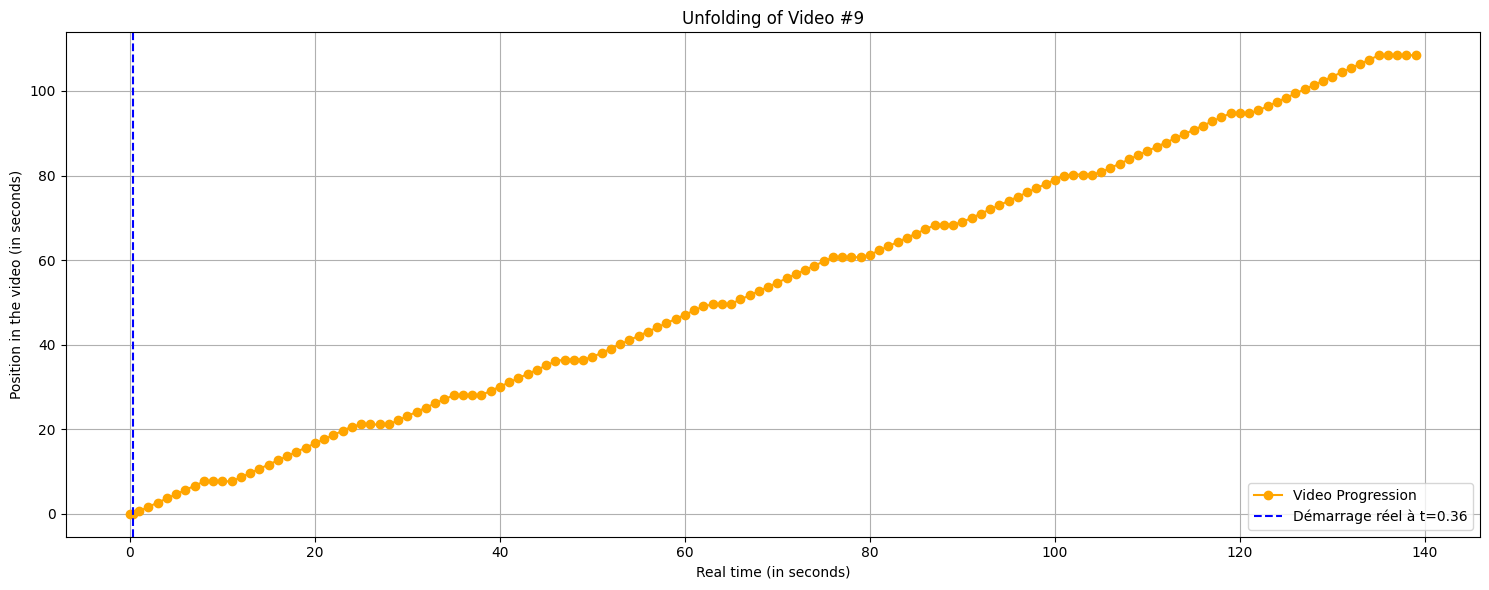

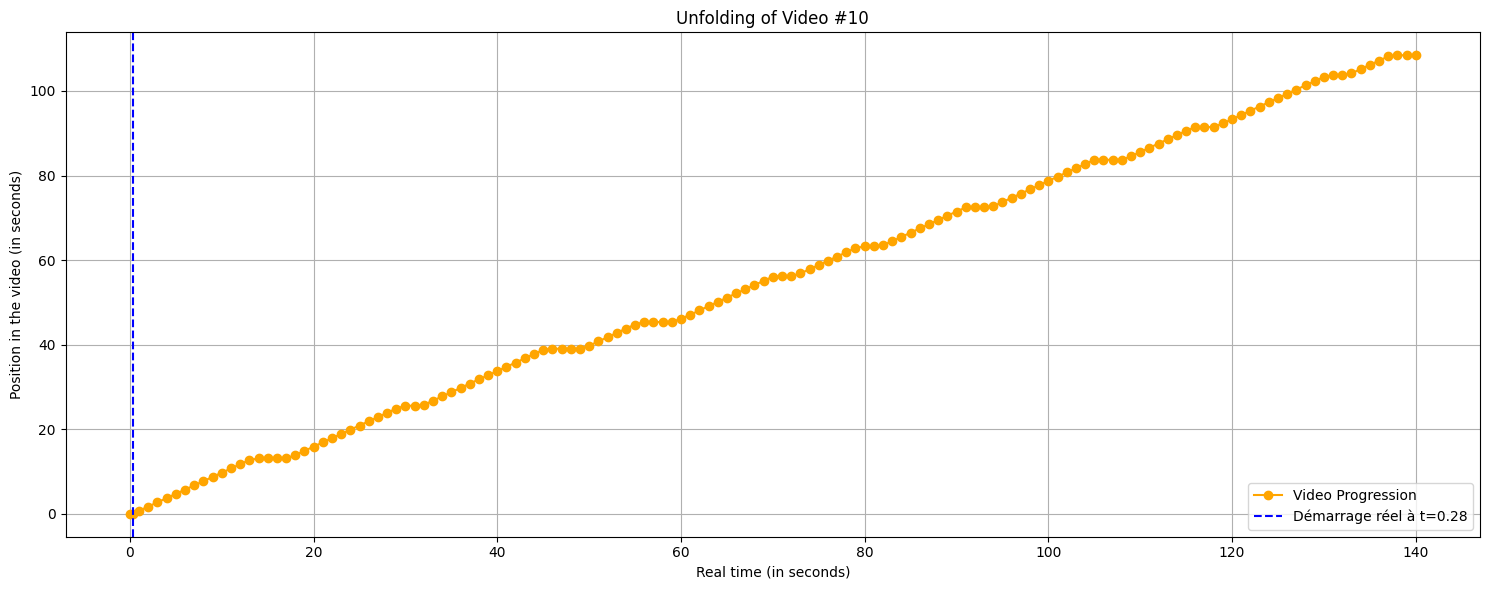

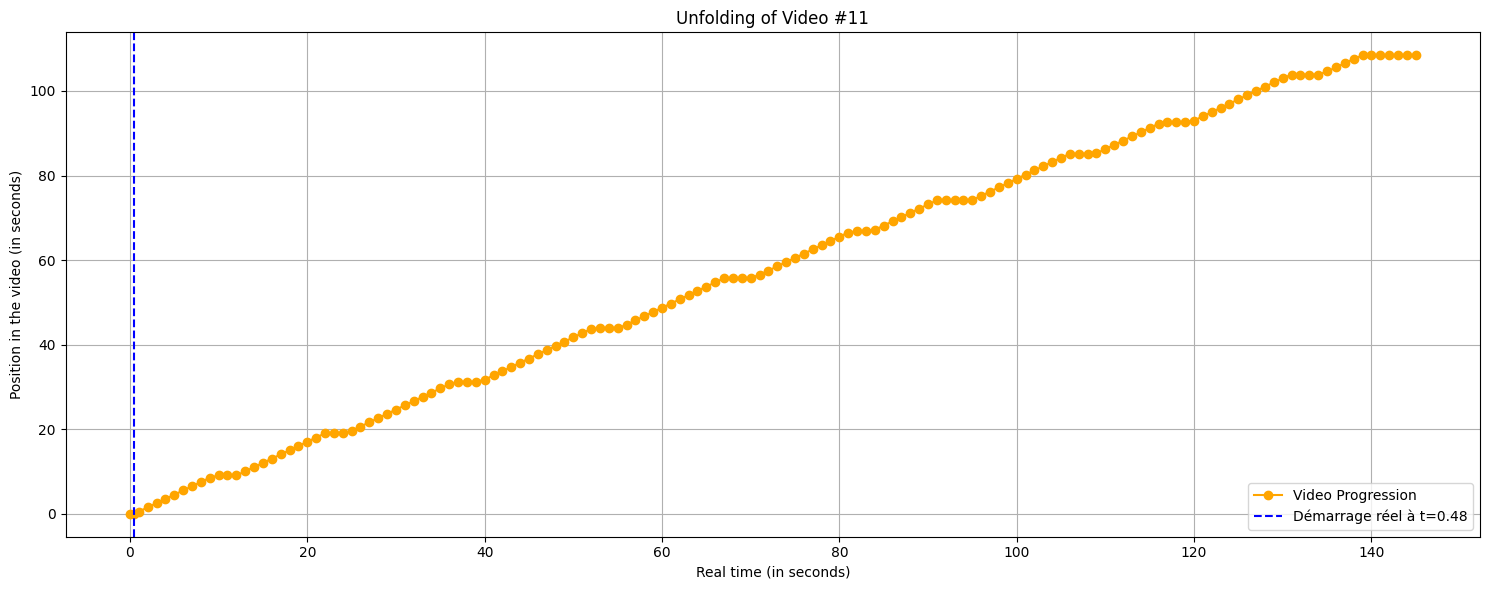

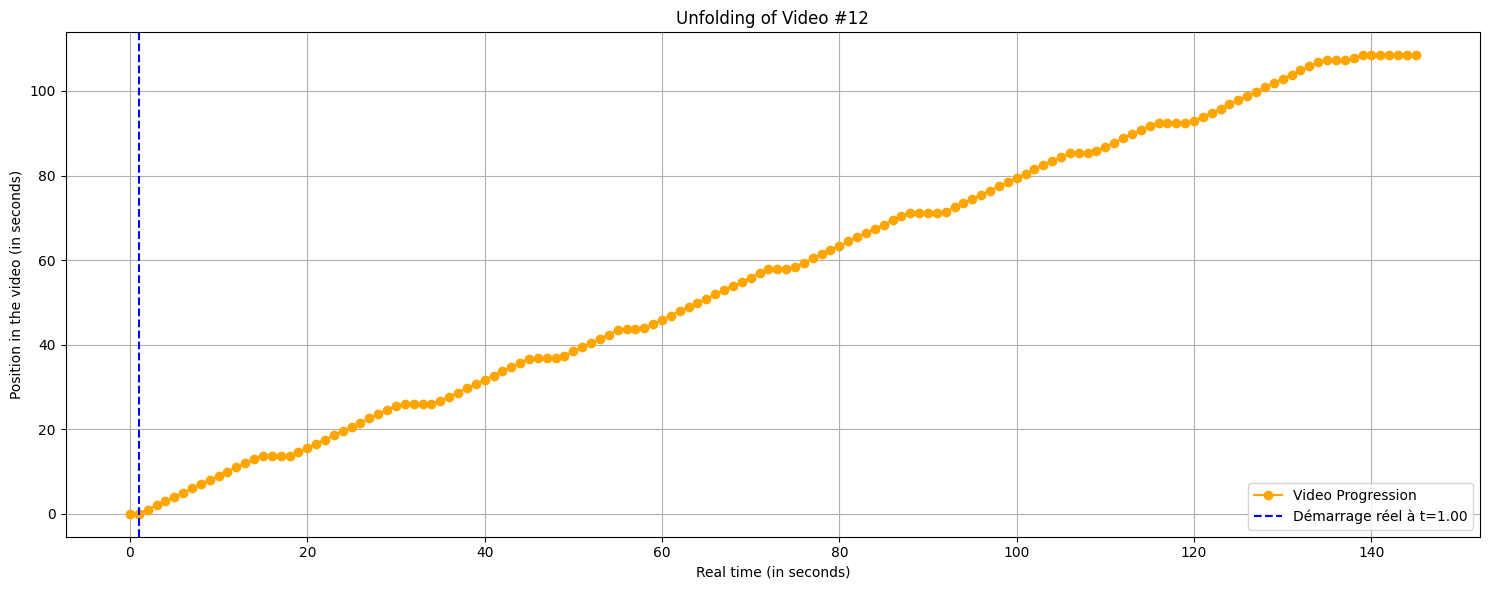

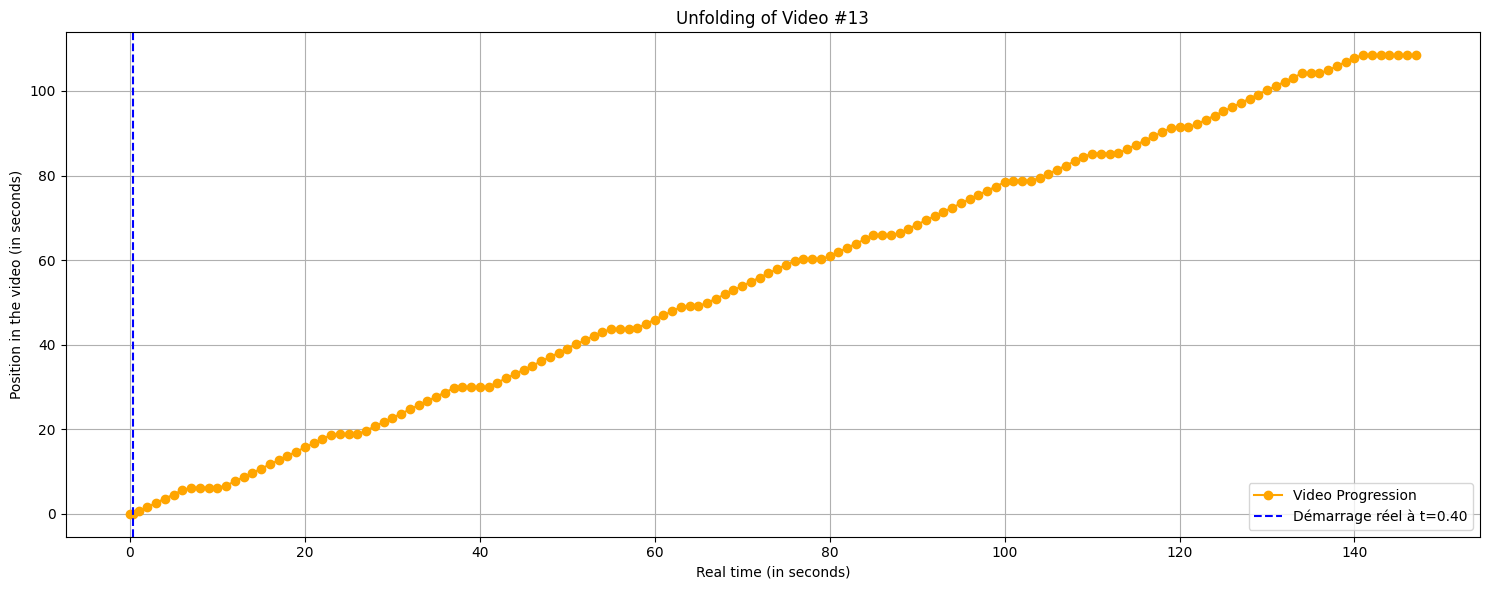

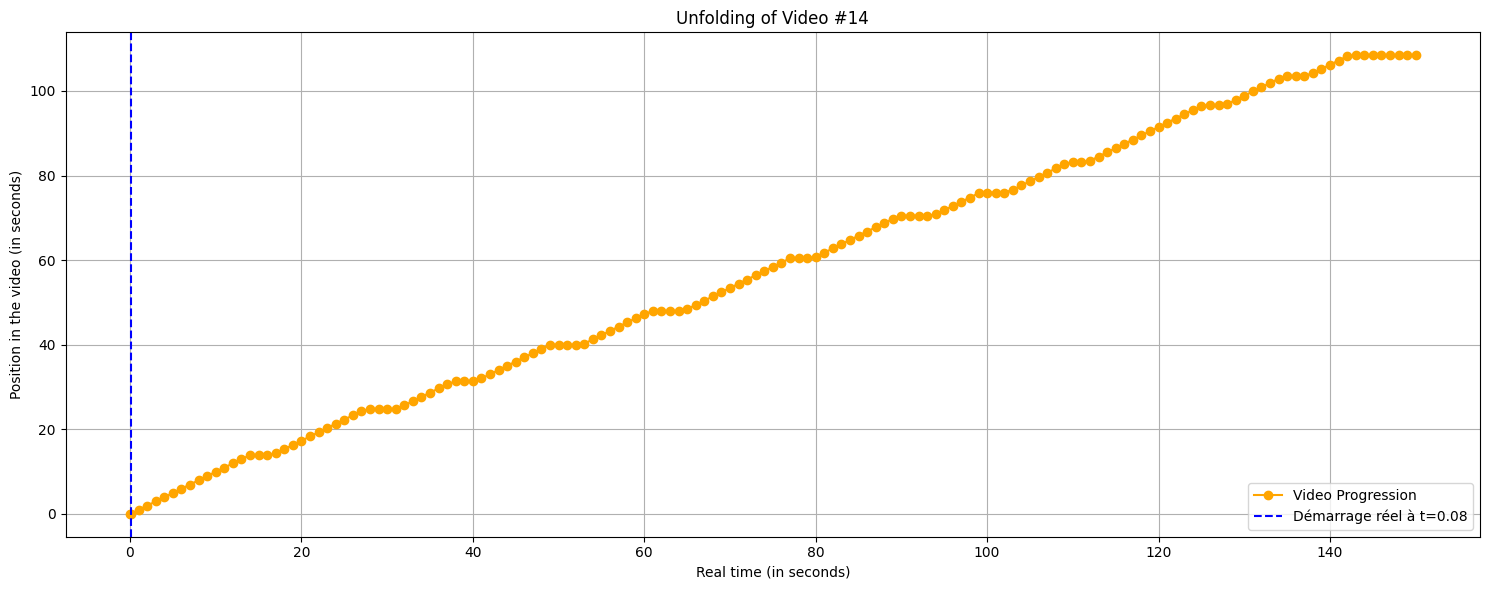

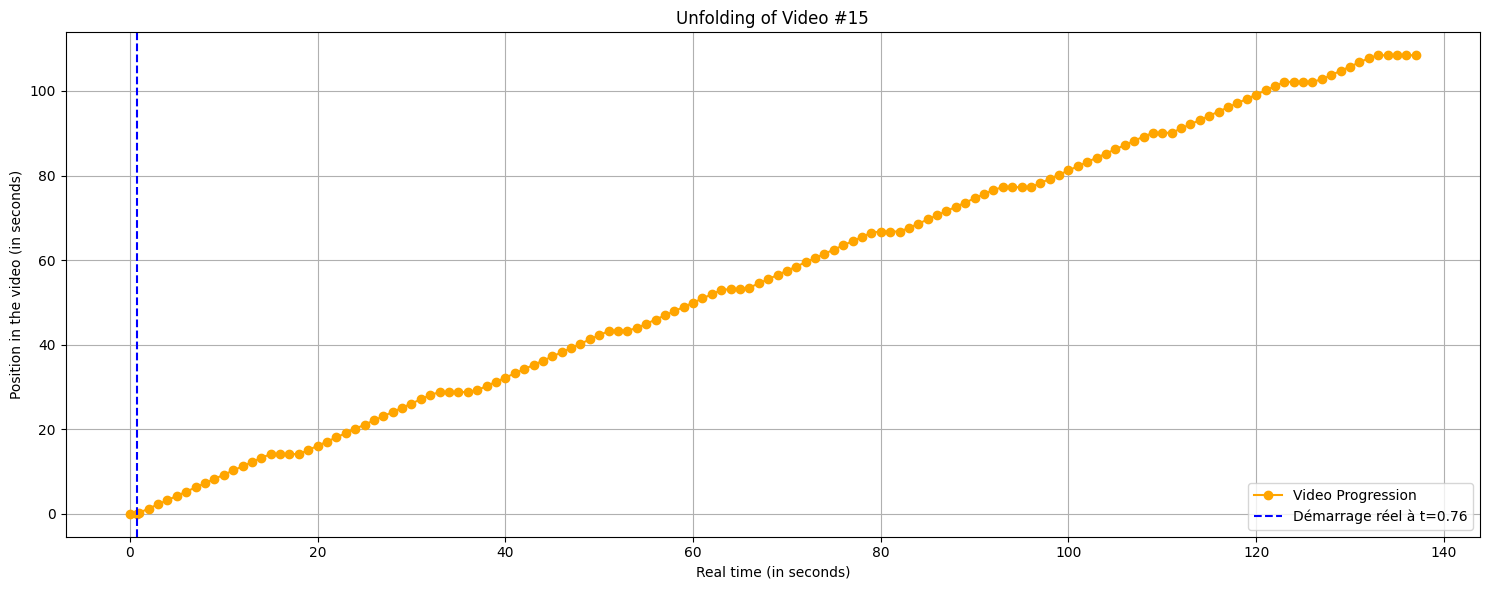

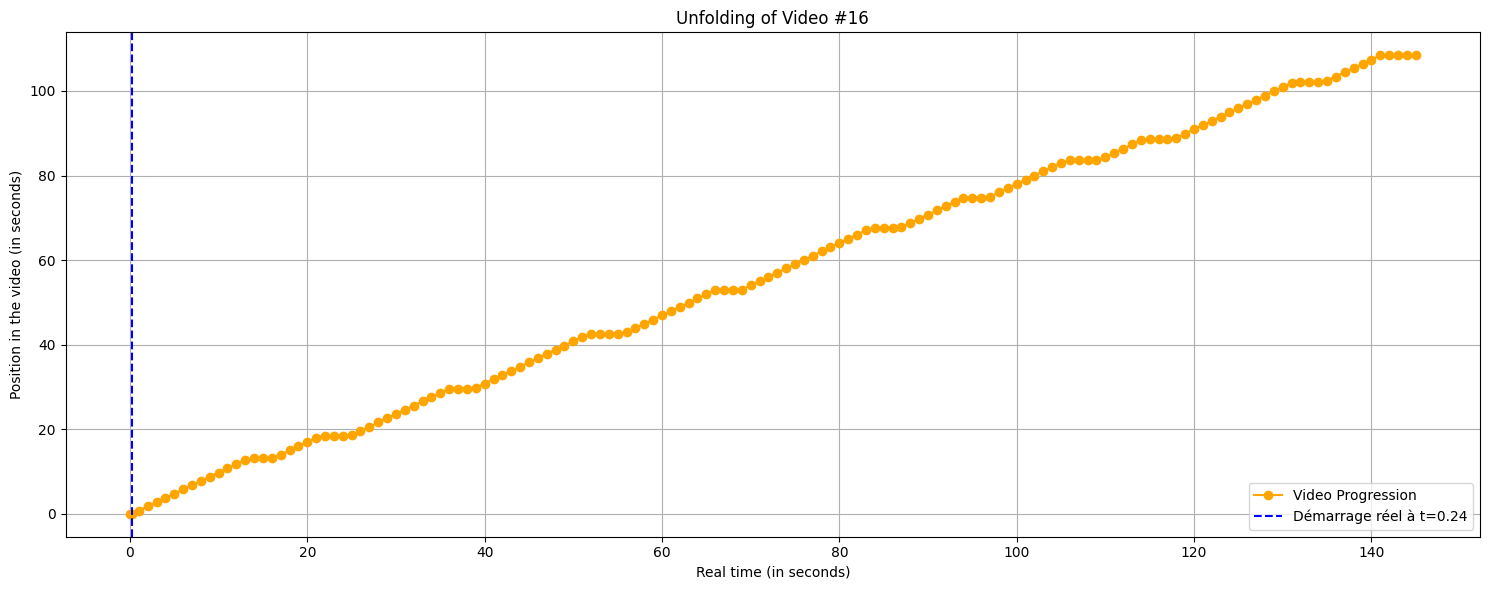

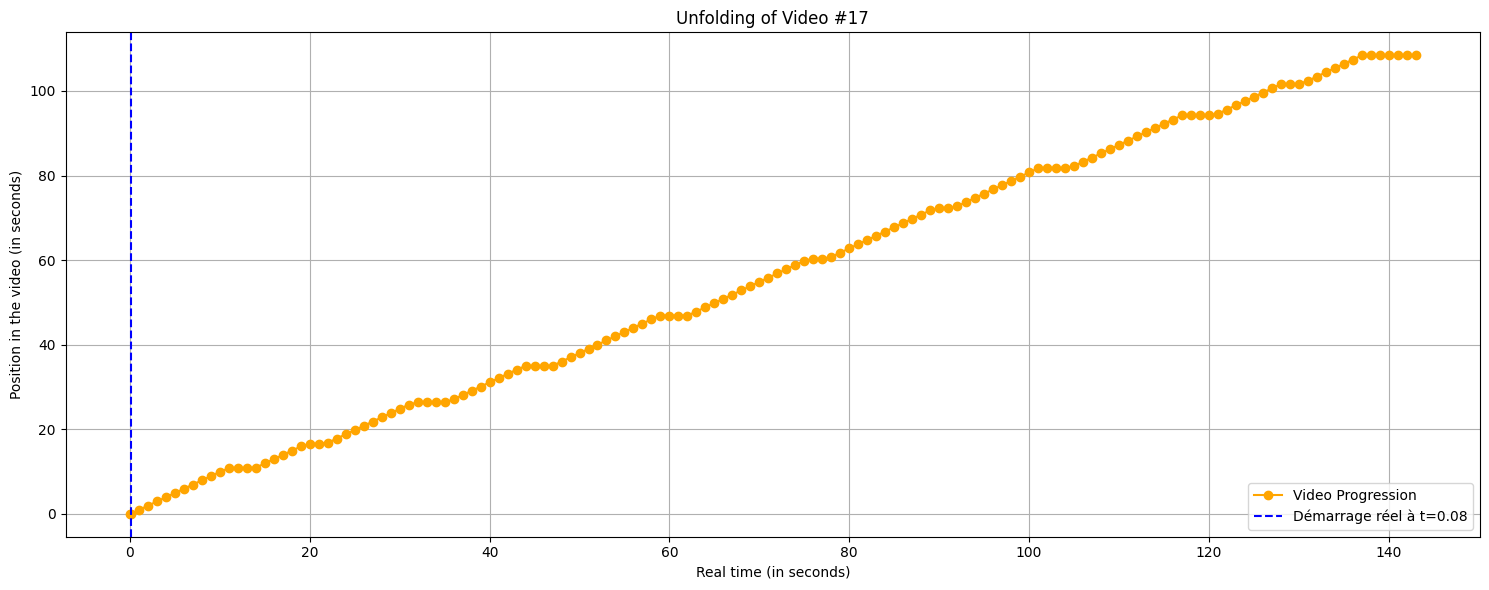

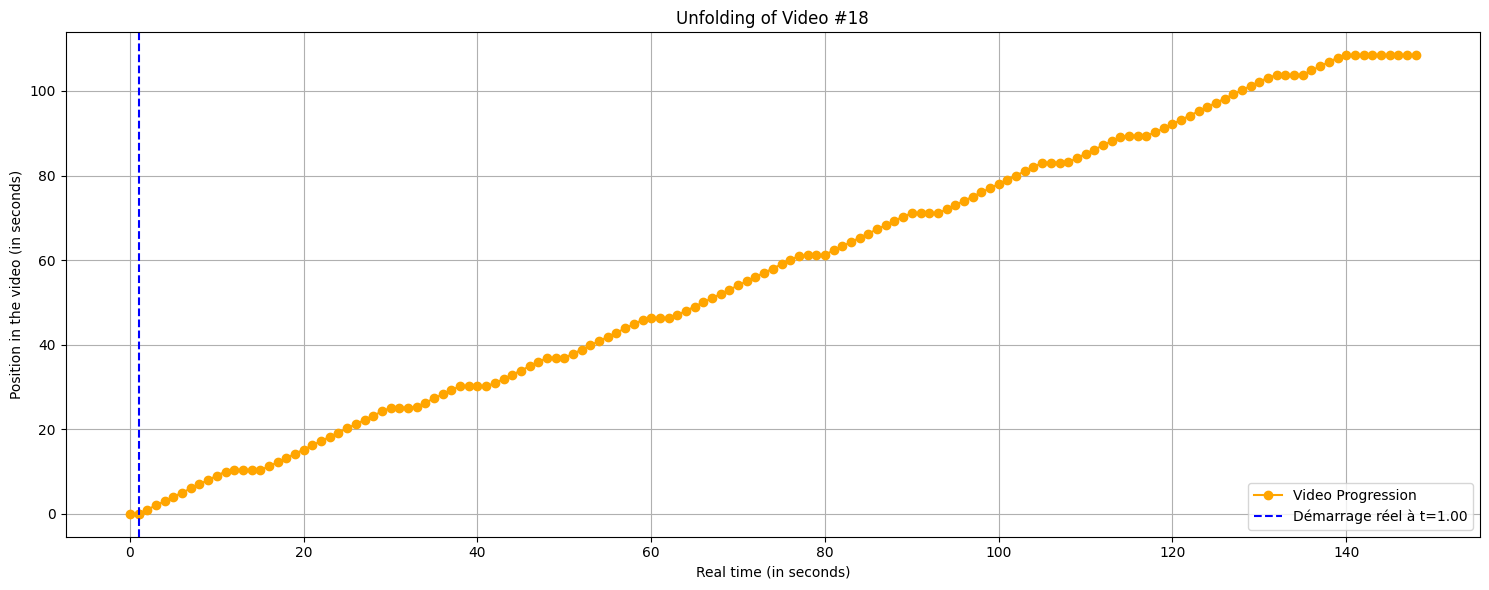

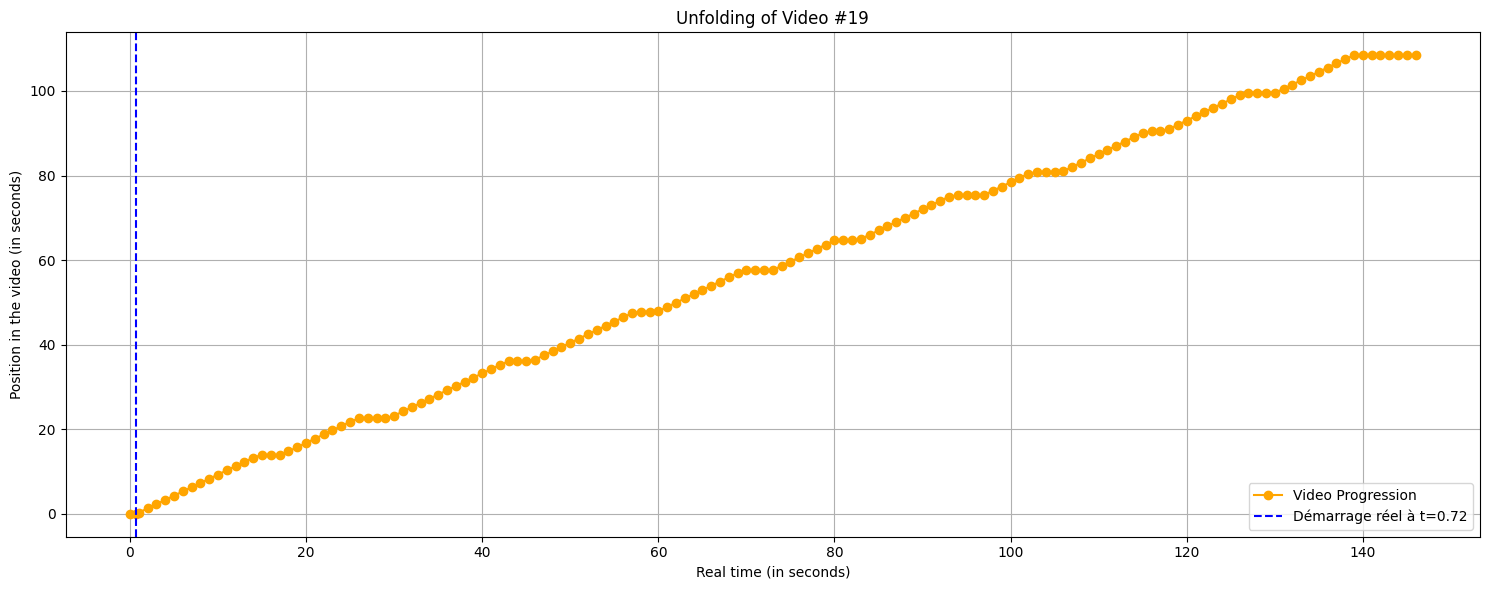

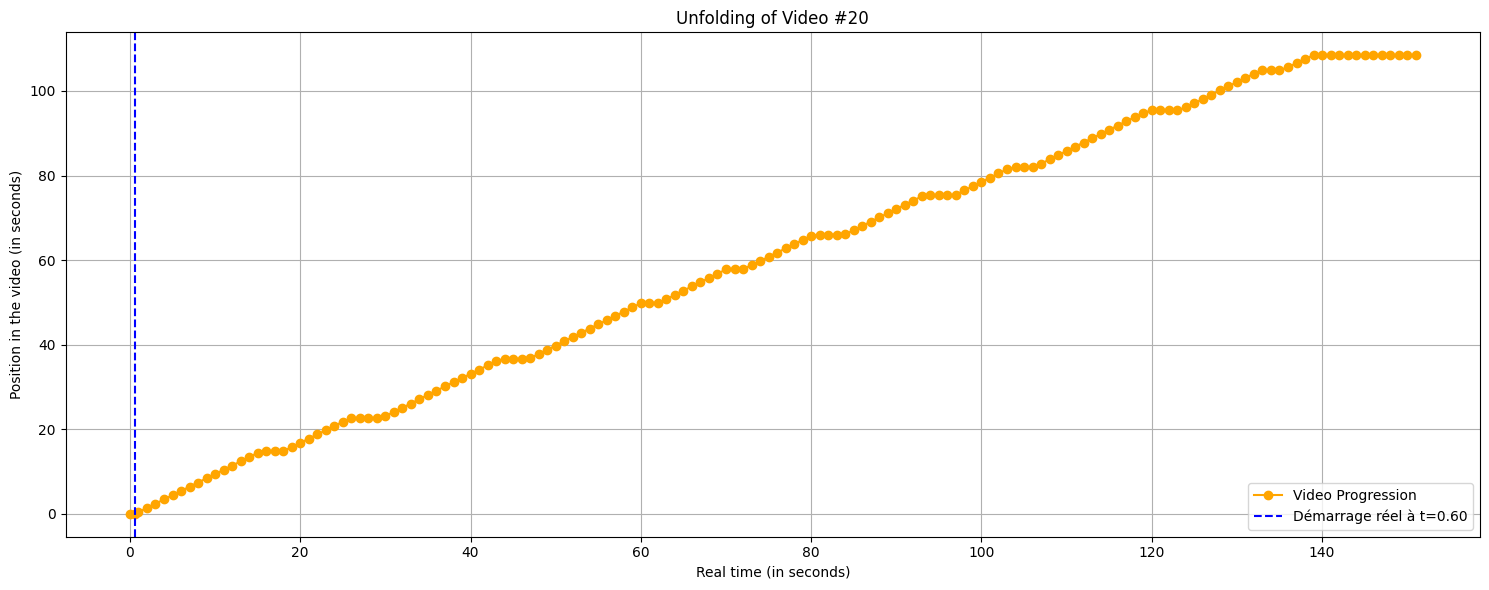

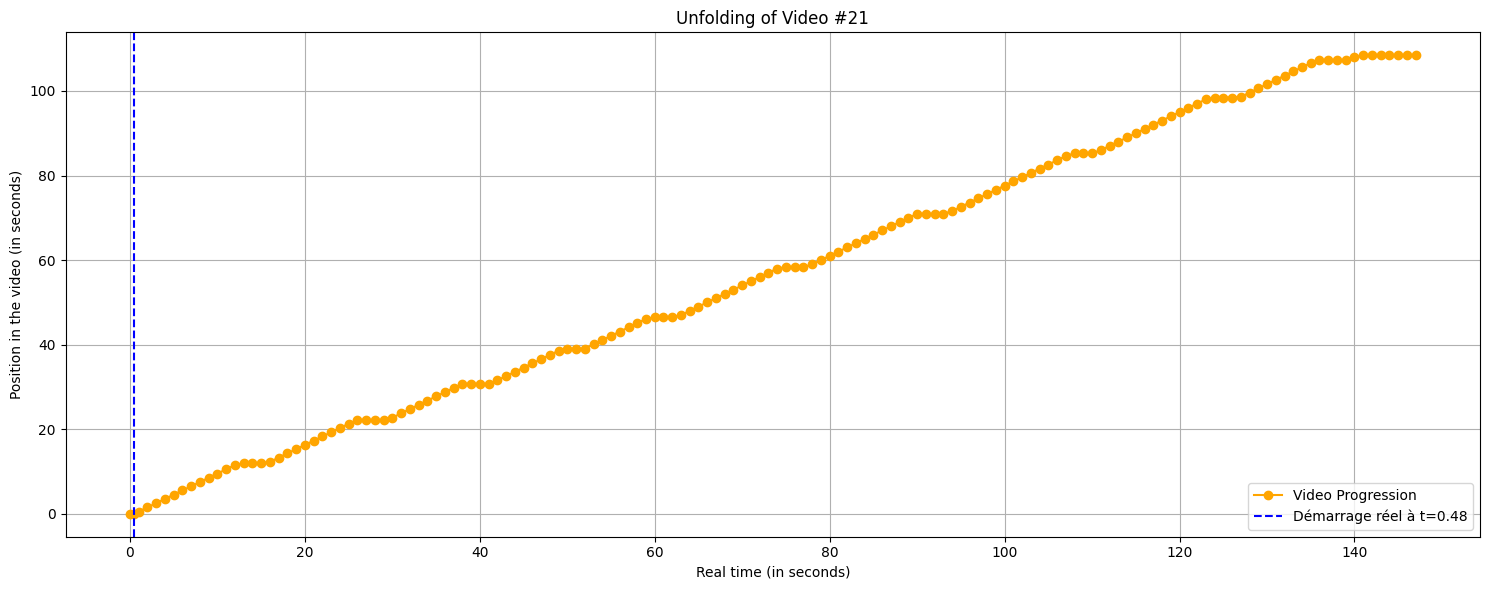

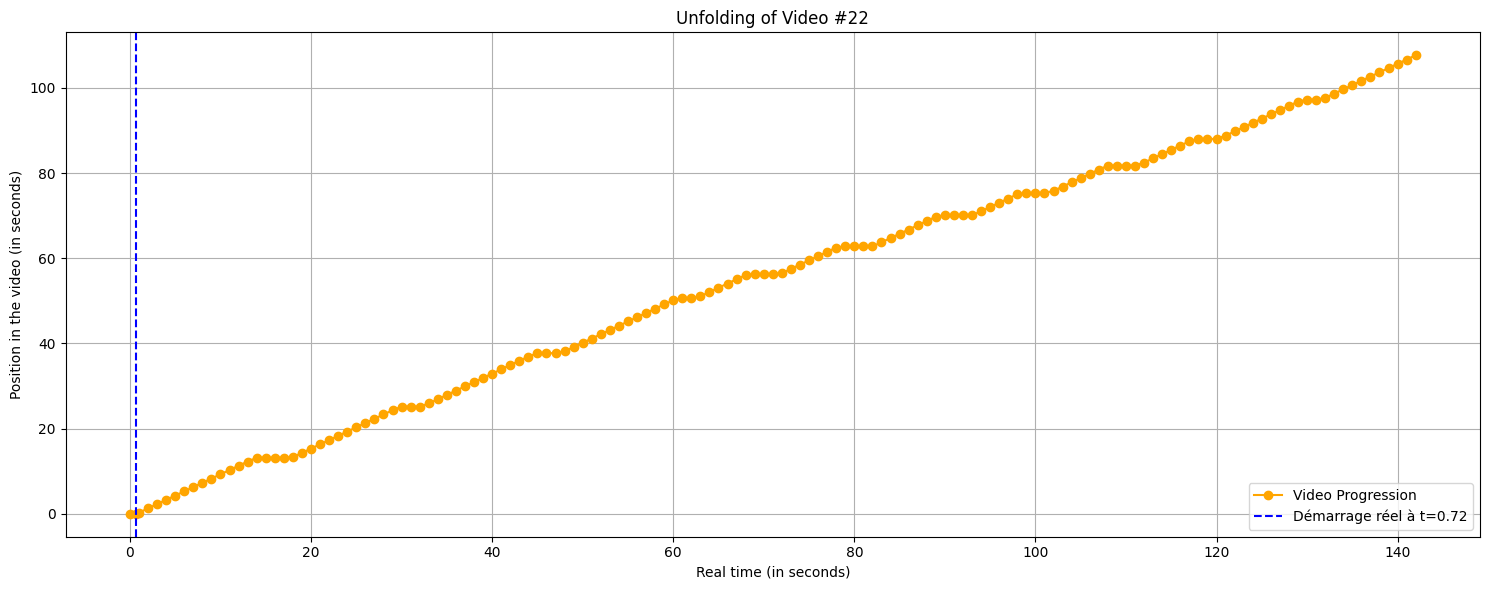

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("qoe_data_received_multiple.csv", sep=";")

df["videoTime"] = df["videoTime"].astype(str).str.replace(",", ".").astype(float)
df["bufferingCount"] = pd.to_numeric(df["bufferingCount"], errors="coerce")

unique_videos = df["bufferingCount"].dropna().unique()
unique_videos.sort()

segments_by_video = [df[df["bufferingCount"] == vid].copy() for vid in unique_videos]

for i, segment in enumerate(segments_by_video):
    segment = segment.copy()
    segment["videoTime"] = segment["videoTime"].astype(float)

    start_value = segment["videoTime"].iloc[0]
    start_time = 1.0 - start_value

    p0 = pd.DataFrame([{"realTime": 0.0, "videoTime": 0.0}])
    p1 = pd.DataFrame([{"realTime": start_time, "videoTime": 0.0}])

    segment["realTime"] = np.arange(1.0, 1.0 + len(segment), 1.0)
    segment_plot = pd.concat([p0, p1, segment], ignore_index=True)

    plt.figure(figsize=(15, 6))
    plt.plot(segment_plot["realTime"], segment_plot["videoTime"],
             color='orange', marker='o', label="Video Progression")
    plt.axvline(x=start_time, color='blue', linestyle='--',
                label=f"Démarrage réel à t={start_time:.2f}")
    plt.title(f"Unfolding of Video #{int(segment['bufferingCount'].iloc[0])}")
    plt.xlabel("Real time (in seconds)")
    plt.ylabel("Position in the video (in seconds)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [19]:
print("Statistics per video :\n")

start_times = []

for vid in unique_videos:
    segment = df[df["bufferingCount"] == vid].copy()
    if not segment.empty:
        start_value = segment["videoTime"].iloc[0]
        start_time = 1.0 - start_value
        start_times.append(start_time)

start_times = np.array(start_times)

print("Time to start all the videos : ")
for i, val in enumerate(start_times, 1):
    print(f"▶ Vidéo {i} : start_time = {val:.2f} s")
print(f"▶ Min  : {start_times.min():.2f} s")
print(f"▶ Mean : {start_times.mean():.2f} s")
print(f"▶ Max  : {start_times.max():.2f} s")

Statistics per video :

Time to start all the videos : 
▶ Vidéo 1 : start_time = 0.12 s
▶ Vidéo 2 : start_time = 0.12 s
▶ Vidéo 3 : start_time = 0.84 s
▶ Vidéo 4 : start_time = 1.00 s
▶ Vidéo 5 : start_time = 0.28 s
▶ Vidéo 6 : start_time = 0.04 s
▶ Vidéo 7 : start_time = 0.28 s
▶ Vidéo 8 : start_time = 0.68 s
▶ Vidéo 9 : start_time = 0.36 s
▶ Vidéo 10 : start_time = 0.28 s
▶ Vidéo 11 : start_time = 0.48 s
▶ Vidéo 12 : start_time = 1.00 s
▶ Vidéo 13 : start_time = 0.40 s
▶ Vidéo 14 : start_time = 0.08 s
▶ Vidéo 15 : start_time = 0.76 s
▶ Vidéo 16 : start_time = 0.24 s
▶ Vidéo 17 : start_time = 0.08 s
▶ Vidéo 18 : start_time = 1.00 s
▶ Vidéo 19 : start_time = 0.72 s
▶ Vidéo 20 : start_time = 0.60 s
▶ Vidéo 21 : start_time = 0.48 s
▶ Vidéo 22 : start_time = 0.72 s
▶ Min  : 0.04 s
▶ Mean : 0.48 s
▶ Max  : 1.00 s


In [20]:
import pandas as pd

df = pd.read_csv("qoe_data_received_multiple.csv", sep=";")
df["videoTime"] = df["videoTime"].astype(str).str.replace(",", ".").astype(float)
df["delta"] = df["videoTime"].diff().fillna(0)

freeze_frames = df[df["delta"] == 0].shape[0]
total_frames = df.shape[0]

freeze_percentage = (freeze_frames / total_frames) * 100

In [21]:
df = pd.read_csv("qoe_data_received_multiple.csv", sep=";")
df["videoTime"] = df["videoTime"].astype(str).str.replace(",", ".").astype(float)
df["bufferingCount"] = pd.to_numeric(df["bufferingCount"], errors="coerce")

videos = df["bufferingCount"].dropna().unique()
videos.sort()

results = []

def zone_classification(t, start_limit, end_limit):
    if t <= start_limit:
        return "start"
    elif t >= end_limit:
        return "end"
    else:
        return "middle"

for vid in videos:
    video_df = df[df["bufferingCount"] == vid].copy()
    if video_df.empty:
        continue

    video_df["delta"] = video_df["videoTime"].diff().fillna(0)

    total_duration = video_df["videoTime"].max()
    start_time = 1.0 - video_df["videoTime"].iloc[0]
    start_limit = total_duration * 0.10
    end_limit = total_duration * 0.90

    video_df["zone"] = video_df["videoTime"].apply(lambda t: zone_classification(t, start_limit, end_limit))

    total_counts = video_df.groupby("zone").size()
    freeze_counts = video_df[video_df["delta"] == 0].groupby("zone").size()

    result = pd.DataFrame({
        "video": int(vid),
        "total_frames": total_counts,
        "freeze_frames": freeze_counts
    }).fillna(0)

    result["freeze_percent"] = (result["freeze_frames"] / result["total_frames"]) * 100
    results.append(result)

final_result = pd.concat(results).reset_index()


In [22]:
def extract_freeze_time(serie):
    serie = serie.astype(str)
    times = serie.str.extract(r'(\d+,\d+)s', expand=False)
    return times.str.replace(',', '.', regex=False).astype(float)


values = extract_freeze_time(df['freezes'])
mean = values.mean()
min = values.min()
max = values.max()

In [23]:
freeze_frames = final_result["freeze_frames"].sum()
total_frames = final_result["total_frames"].sum()
freeze_percentage = (freeze_frames / total_frames) * 100

mean = values.mean()
min_val = values.min()
max_val = values.max()
mean_start_time = np.mean(start_times)

print(f"❄ Percentage of Freeze : {freeze_percentage:.2f}% ({int(freeze_frames)} over {int(total_frames)} measures)")

for zone in ["start", "middle", "end"]:
    zone_data = final_result[final_result["zone"] == zone]
    if not zone_data.empty:
        zone_total = zone_data["total_frames"].sum()
        zone_freeze = zone_data["freeze_frames"].sum()
        zone_percent = (zone_freeze / zone_total) * 100
        print(f"❄ Freeze in the {zone} zone : {zone_percent:.2f}% over {int(zone_total)} measures")
    else:
        print(f"⚠️ No data in the {zone} zone.")

print(f"\n❄ Mean freeze duration : {mean:.2f}s")
print(f"❄ Min freeze duration  : {min_val:.2f}s")
print(f"❄ Max freeze duration  : {max_val:.2f}s")
print(f"\n⏱ Average video start time : {mean_start_time * 1000:.2f} ms")

❄ Percentage of Freeze : 19.48% (628 over 3224 measures)
❄ Freeze in the start zone : 15.21% over 263 measures
❄ Freeze in the middle zone : 16.23% over 2495 measures
❄ Freeze in the end zone : 39.27% over 466 measures

❄ Mean freeze duration : 3.06s
❄ Min freeze duration  : 2.05s
❄ Max freeze duration  : 4.04s

⏱ Average video start time : 480.00 ms


In [24]:
df["bufferingCount"] = pd.to_numeric(df["bufferingCount"], errors="coerce")
df["freezes"] = df["freezes"].astype(str)

def extract_freeze_time(serie):
    serie = serie.astype(str)
    times = serie.str.extract(r'(\d+,\d+)s', expand=False)
    return times.str.replace(',', '.', regex=False).astype(float)

freeze_summary = []

videos = df["bufferingCount"].dropna().unique()
videos.sort()

for vid in videos:
    segment = df[df["bufferingCount"] == vid].copy()
    if segment.empty:
        continue

    freeze_durations = extract_freeze_time(segment["freezes"])

    freeze_count = freeze_durations.notna().sum()
    freeze_mean = freeze_durations.mean()

    freeze_summary.append({
        "video": int(vid),
        "freeze_count": freeze_count,
        "mean_freeze_duration": round(freeze_mean, 2) if not pd.isna(freeze_mean) else 0.0
    })

freeze_summary_df = pd.DataFrame(freeze_summary)
freeze_summary_df

,video,freeze_count,mean_freeze_duration
0,1,11,3.18
1,2,11,3.27
2,3,12,3.19
3,4,11,3.12
4,5,13,2.77
5,6,12,3.05
6,7,11,3.20
7,8,11,3.21
8,9,10,2.93
9,10,11,2.91


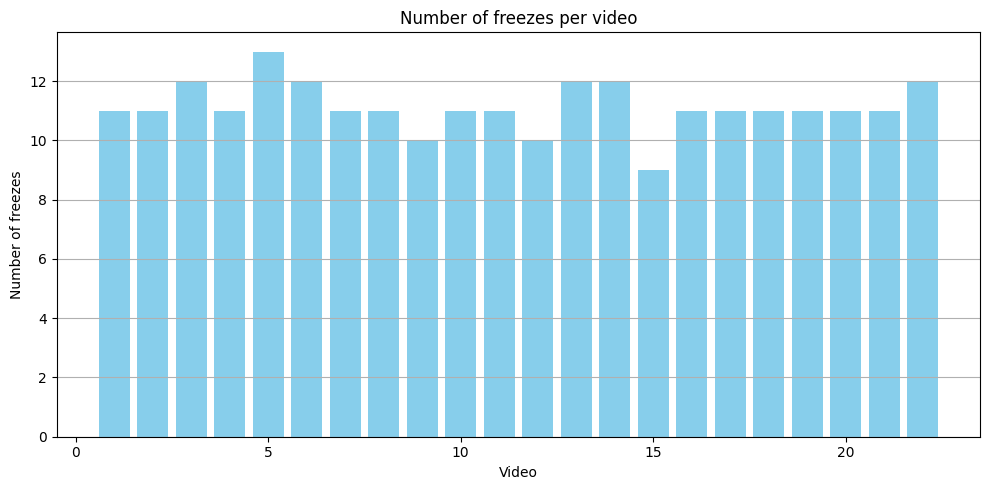

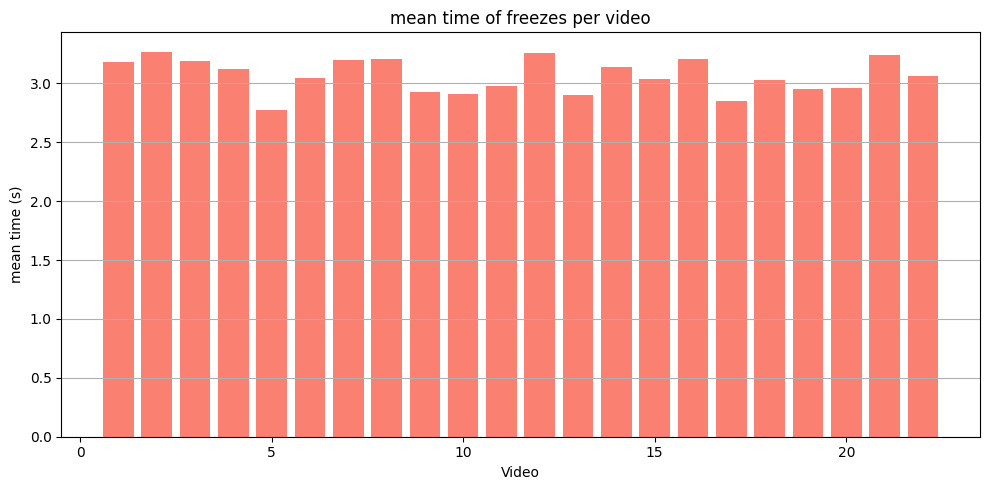

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(freeze_summary_df["video"], freeze_summary_df["freeze_count"], color='skyblue')
plt.title("Number of freezes per video")
plt.xlabel("Video")
plt.ylabel("Number of freezes")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(freeze_summary_df["video"], freeze_summary_df["mean_freeze_duration"], color='salmon')
plt.title("mean time of freezes per video")
plt.xlabel("Video")
plt.ylabel("mean time (s)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()